In [1]:
from google.colab import files
upload = files.upload()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 1: Unzip the Dataset

In [3]:
import zipfile
import os

# Identify the name of your zip file (usually it's the one you dragged in)
zip_file_name = '/content/cat vs dog dataset.zip'

# Extracting the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

print("Extraction complete! Check your file sidebar on the left.")

Extraction complete! Check your file sidebar on the left.


Step 2: Clean and Organize

In [4]:
import tensorflow as tf

base_dir = '/content/dataset/kagglecatsanddogs_3367a/PetImages' # Adjust this if your unzip created a different folder structure

# List the folders to make sure we see 'Cat' and 'Dog'
print("Folders found:", os.listdir(base_dir))

# Cleaning: Removing images that are zero bytes or not actual JPEGs
import os
for category in ['Cat', 'Dog']:
    folder_path = os.path.join(base_dir, category)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        # Delete if the file is empty or named incorrectly
        if os.path.getsize(file_path) == 0:
            os.remove(file_path)
            print(f"Deleted corrupted file: {file}")

Folders found: ['Dog', 'Cat']


In [13]:
import os
import PIL
from PIL import Image

# This script physically opens every image to check if it's broken
base_dir = '/content/dataset/kagglecatsanddogs_3367a/PetImages'
num_skipped = 0

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(base_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} corrupted images that were causing the crash.")

Deleted 1580 corrupted images that were causing the crash.


Step 3: Load the Images into TensorFlow

In [14]:
# Parameters
batch_size = 32
img_height = 180
img_width = 180

# Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23379 files belonging to 2 classes.
Using 18704 files for training.
Found 23379 files belonging to 2 classes.
Using 4675 files for validation.


Step 4: Speed up Data Loading (The "Pro" Move)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

1. BUILD THE MODEL

In [8]:
# We use a standard CNN architecture: Conv2D for feature extraction,
# MaxPooling to reduce dimensions, and Dense layers for classification.

model = models.Sequential([
    # Rescaling layer to normalize pixel values from [0, 255] to [0, 1]
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Helps prevent overfitting
    layers.Dense(1, activation='sigmoid') # Binary output: 0 (Cat) or 1 (Dog)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2. COMPILE THE MODEL

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,647,105 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

3. TRAIN THE MODEL

In [15]:
# We'll start with 10 epochs. This might take 5-10 minutes on a GPU.
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.6004 - loss: 0.6696 - val_accuracy: 0.7318 - val_loss: 0.5149
Epoch 2/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.7413 - loss: 0.5230 - val_accuracy: 0.7767 - val_loss: 0.4658
Epoch 3/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.7900 - loss: 0.4507 - val_accuracy: 0.8218 - val_loss: 0.3945
Epoch 4/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.8307 - loss: 0.3816 - val_accuracy: 0.7876 - val_loss: 0.4729
Epoch 5/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.8580 - loss: 0.3260 - val_accuracy: 0.8445 - val_loss: 0.3700
Epoch 6/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.8934 - loss: 0.2549 - val_accuracy: 0.8413 - val_loss: 0.3980
Epoch 7/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.9183 - loss: 0.1941 - val_accuracy: 0.8167 - val_loss: 0.4755
Epoch 8/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.9358 - loss: 0.1609 - 

4. VISUALIZE THE RESULTS

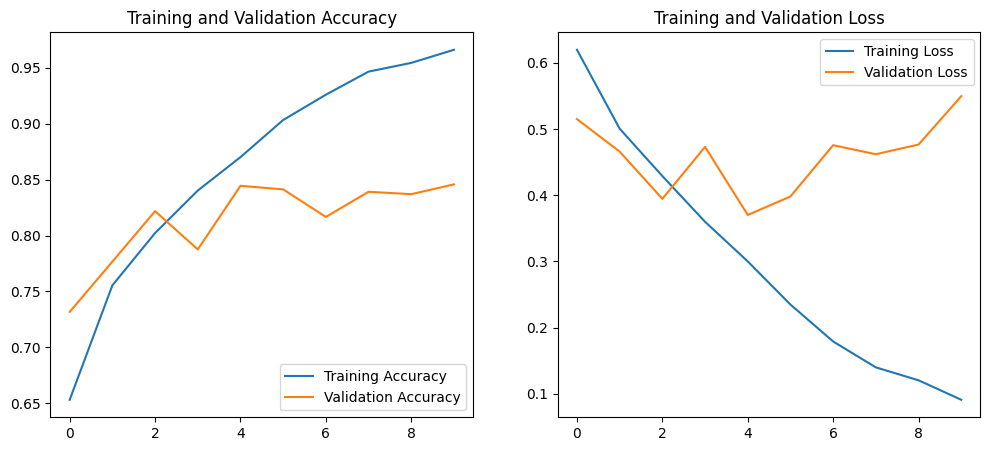

In [16]:
# This creates the graphs required for your assignment
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [17]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
    # Predicting images
    path = '/content/' + fn
    img = load_img(path, target_size=(180, 180))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    classes = model.predict(x)

    if classes[0] > 0.5:
        print(f"{fn} is a DOG")
    else:
        print(f"{fn} is a CAT")

Saving imagetest.JPG to imagetest.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
imagetest.JPG is a CAT
